In [3]:
# 딥러닝 모형 학습을 위한 기능 import
# -*- coding: utf-8 -*-
#%tensorflow_version 1.x
import tensorflow as tf

import pandas as pd
import numpy as np

import datetime
import os
import glob

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

from statsmodels.distributions.empirical_distribution import ECDF
#!pip install h5py==2.10.0

%matplotlib inline
print(tf.__version__)

2.4.2


In [10]:
# 14년1월 ~ 21년 6월까지 데이터를 활용
# openAPI를 통해 6개월 단위로 수집가능함에 따라, 병합처리 필요

path = '../data/jk_b/'

raw_period = {'startdt': ['20140101', '20140701', '20150101', '20150701', '20160101', '20160701', '20170101', '20170701', '20180101', '20180701', '20190101', '20190701', '20200101', '20200701', '20210101'],
                'enddt': ['20140630', '20141231', '20150630', '20151231', '20160630', '20161231', '20170630', '20171231', '20180630', '20181231', '20190630', '20191231', '20200630', '20201231', '20210630']}

df_period = pd.DataFrame(raw_period)
df_period

,startdt,enddt
0,20140101,20140630
1,20140701,20141231
2,20150101,20150630
3,20150701,20151231
4,20160101,20160630
5,20160701,20161231
6,20170101,20170630
7,20170701,20171231
8,20180101,20180630
9,20180701,20181231


In [11]:
# 진관교 및 상류지역 수위 및 강우량 지점 코드 
# 해당 코드명이 파일 이름으로 포함되어 있음

raw_obscd = {'obscd': ['1018620', '1018625', '1018630', '10184110', '10184220'],
            'desc': ['수위_남양주시 부평교', '수위_남양주시 내곡교', '수위_남양주시 진관교', '강우_진관교', '강우_진접읍사무소']}

df_obscd = pd.DataFrame(raw_obscd)
df_obscd


,obscd,desc
0,1018620,수위_남양주시 부평교
1,1018625,수위_남양주시 내곡교
2,1018630,수위_남양주시 진관교
3,10184110,강우_진관교
4,10184220,강우_진접읍사무소


In [12]:
# 기준이 되는 Date를 생성함

start = datetime.datetime.strptime("2015050101", "%Y%m%d%H")
end = datetime.datetime.strptime("2020110123", "%Y%m%d%H")
date_generated = [start + datetime.timedelta(hours=x) for x in range(0, (end-start).days * 24 + 23)]

df = pd.DataFrame(date_generated, columns =['Date'])
df['ymdh'] = df['Date'].apply(lambda x: int(x.strftime('%Y%m%d%H'))) 
df

,Date,ymdh
0,2015-05-01 01:00:00,2015050101
1,2015-05-01 02:00:00,2015050102
2,2015-05-01 03:00:00,2015050103
3,2015-05-01 04:00:00,2015050104
4,2015-05-01 05:00:00,2015050105
...,...,...
48282,2020-11-01 19:00:00,2020110119
48283,2020-11-01 20:00:00,2020110120
48284,2020-11-01 21:00:00,2020110121
48285,2020-11-01 22:00:00,2020110122


In [13]:
# 앞에서 만든 데이터프레임을 이용하여, 각 파일들을 읽고 합치는 작업을 함

for i, row_i in df_obscd.iterrows():
  obscd = row_i['obscd']   
  
  files = glob.glob(path + '*' + obscd + '*.csv')
  files.sort()
  print(files)
  
  # Read files
  for index, file in enumerate(files):
    #print('Reading files ... : ' + file)
    try:
      if(index == 0):
        df_wl = pd.read_csv(file)
      else:
        temp = pd.read_csv(file)
        df_wl = df_wl.append(temp)
    except:
      print('Pass file : ' + file)
      continue
  df_wl.columns = ['ymdh', obscd]
  df = df.merge(df_wl, how='left', on = 'ymdh')
  #display(df)

['../data/jk_b/wl_1018620_20140101_20140630.csv', '../data/jk_b/wl_1018620_20140701_20141231.csv', '../data/jk_b/wl_1018620_20150101_20150630.csv', '../data/jk_b/wl_1018620_20150701_20151231.csv', '../data/jk_b/wl_1018620_20160101_20160630.csv', '../data/jk_b/wl_1018620_20160701_20161231.csv', '../data/jk_b/wl_1018620_20170101_20170630.csv', '../data/jk_b/wl_1018620_20170701_20171231.csv', '../data/jk_b/wl_1018620_20180101_20180630.csv', '../data/jk_b/wl_1018620_20180701_20181231.csv', '../data/jk_b/wl_1018620_20190101_20190630.csv', '../data/jk_b/wl_1018620_20190701_20191231.csv', '../data/jk_b/wl_1018620_20200101_20200630.csv', '../data/jk_b/wl_1018620_20200701_20201231.csv', '../data/jk_b/wl_1018620_20210101_20210630.csv']
['../data/jk_b/wl_1018625_20140101_20140630.csv', '../data/jk_b/wl_1018625_20140701_20141231.csv', '../data/jk_b/wl_1018625_20150101_20150630.csv', '../data/jk_b/wl_1018625_20150701_20151231.csv', '../data/jk_b/wl_1018625_20160101_20160630.csv', '../data/jk_b/wl_1

In [14]:
df

,Date,ymdh,1018620,1018625,1018630,10184110,10184220
0,2015-05-01 01:00:00,2015050101,0.20,1.08,-0.21,0.0,0.0
1,2015-05-01 02:00:00,2015050102,0.20,1.08,-0.21,0.0,0.0
2,2015-05-01 03:00:00,2015050103,0.20,1.08,-0.21,0.0,0.0
3,2015-05-01 04:00:00,2015050104,0.20,1.08,-0.22,0.0,0.0
4,2015-05-01 05:00:00,2015050105,0.20,1.08,-0.22,0.0,0.0
...,...,...,...,...,...,...,...
48282,2020-11-01 19:00:00,2020110119,0.15,1.07,-0.11,0.0,0.0
48283,2020-11-01 20:00:00,2020110120,0.15,1.07,-0.11,0.0,0.0
48284,2020-11-01 21:00:00,2020110121,0.15,1.07,-0.10,0.0,0.0
48285,2020-11-01 22:00:00,2020110122,0.15,1.08,-0.10,0.0,0.0


<AxesSubplot:>

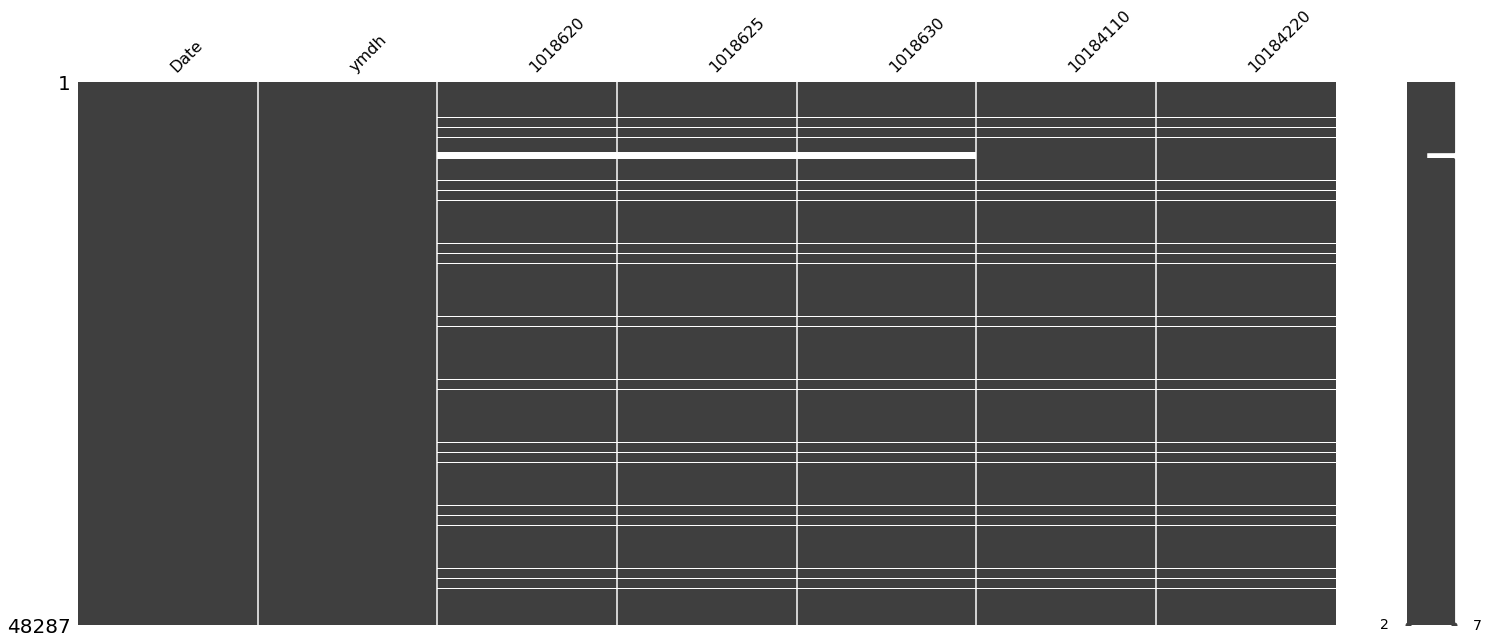

In [15]:
import missingno as msno

msno.matrix(df)

In [16]:
# 결측치는 선형보간으로 처리
# LSTM의 경우 연속된 값을 입력으로 해야함에 따라 결측치 보간을 필수적으로 해야함

df['1018620'] = df['1018620'].interpolate(limit = 1)
df['1018625'] = df['1018625'].interpolate(limit = 1)
df['1018630'] = df['1018630'].interpolate(limit = 1)
df['10184110'] = df['10184110'].fillna(0)
df['10184220'] = df['10184220'].fillna(0)
# 보간 참고

<AxesSubplot:>

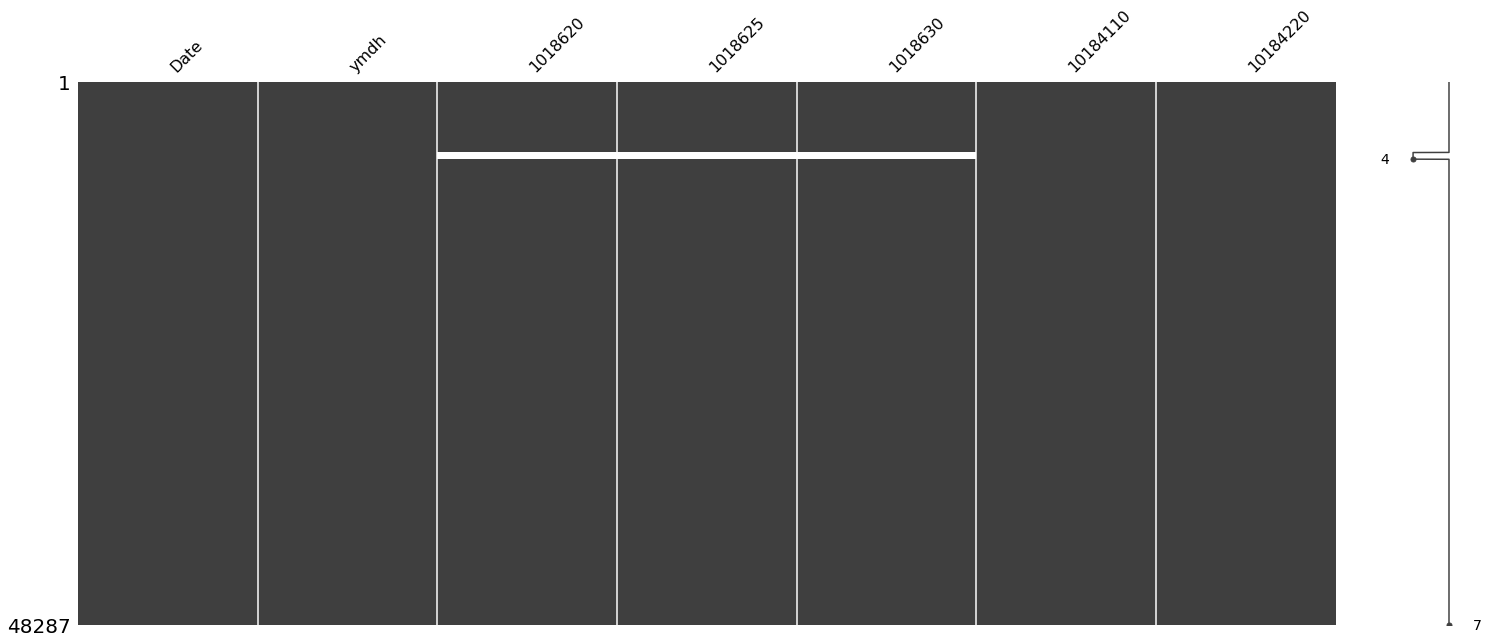

In [17]:
msno.matrix(df)

In [18]:
df.isnull().sum()

Date          0
ymdh          0
1018620     600
1018625     600
1018630     600
10184110      0
10184220      0
dtype: int64

,Date,ymdh,1018620,1018625,1018630,10184110,10184220
46103,2020-08-03 00:00:00,2020080300,1.16,1.645,1.135,0.0,0.0
46104,2020-08-03 01:00:00,2020080301,1.14,1.620,1.130,1.0,0.0
46105,2020-08-03 02:00:00,2020080302,1.15,1.610,1.090,0.0,5.0
46106,2020-08-03 03:00:00,2020080303,1.38,1.620,1.090,13.0,6.0
46107,2020-08-03 04:00:00,2020080304,1.41,1.780,1.200,8.0,1.0
46108,2020-08-03 05:00:00,2020080305,1.43,1.900,1.440,10.0,12.0
46109,2020-08-03 06:00:00,2020080306,1.71,2.100,1.700,15.0,7.0
46110,2020-08-03 07:00:00,2020080307,1.59,2.550,2.170,10.0,16.0
46111,2020-08-03 08:00:00,2020080308,1.49,2.350,2.000,2.0,8.0
46112,2020-08-03 09:00:00,2020080309,1.80,2.530,1.990,22.0,20.0


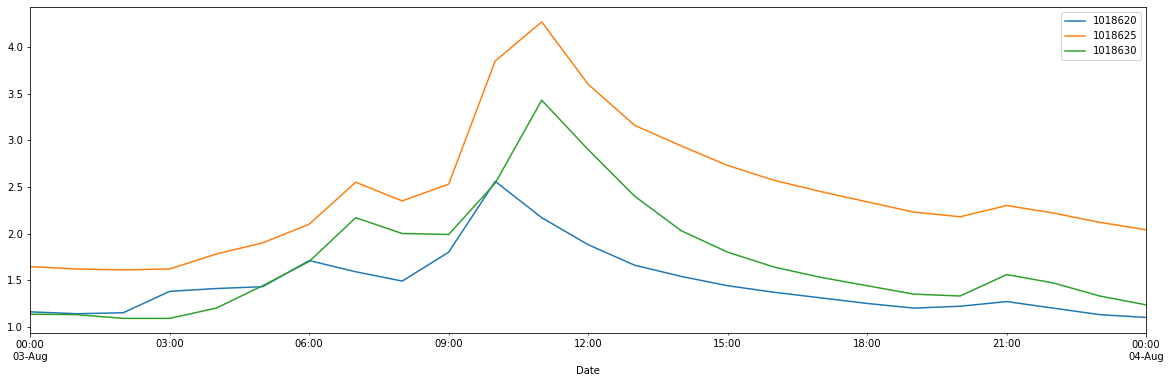

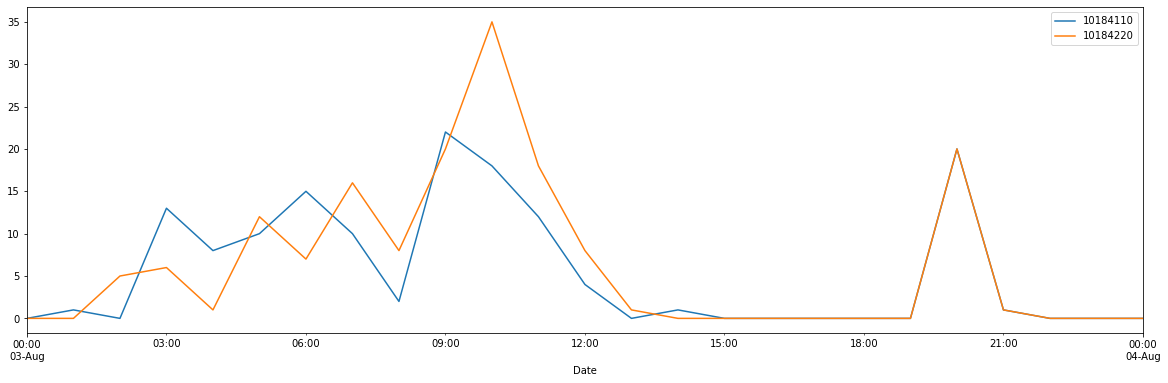

In [19]:
# 데이터 구조 체크 및 시각화

start = 2020080300
end = 2020080400

df_temp = df[(df['ymdh'] >= start) & (df['ymdh'] <= end)][['Date', '1018620', '1018625', '1018630']].set_index('Date')
df_temp.plot(figsize=(20,6))
df_temp = df[(df['ymdh'] >= start) & (df['ymdh'] <= end)][['Date', '10184110', '10184220']].set_index('Date')
df_temp.plot(figsize=(20,6))

display(df[(df['ymdh'] >= start) & (df['ymdh'] <= end)])

In [20]:
# 3차원 입력데이터를 만들기 위해 df_in이라는 데이터프레임으로 복사

df_in = df.drop(columns = ['Date', 'ymdh']).copy()
df_in

,1018620,1018625,1018630,10184110,10184220
0,0.20,1.08,-0.21,0.0,0.0
1,0.20,1.08,-0.21,0.0,0.0
2,0.20,1.08,-0.21,0.0,0.0
3,0.20,1.08,-0.22,0.0,0.0
4,0.20,1.08,-0.22,0.0,0.0
...,...,...,...,...,...
48282,0.15,1.07,-0.11,0.0,0.0
48283,0.15,1.07,-0.11,0.0,0.0
48284,0.15,1.07,-0.10,0.0,0.0
48285,0.15,1.08,-0.10,0.0,0.0


In [21]:
df_in[30000:].isnull().sum()

1018620     0
1018625     0
1018630     0
10184110    0
10184220    0
dtype: int64

In [22]:
# 값들을 0~1로 Min-Max 정규화 처리함

# define scaler
scaler = MinMaxScaler()
# fit scaler on the training dataset
scaler.fit(df_in.values)
# transform the training dataset
df_in_scaled = pd.DataFrame(scaler.transform(df_in.values), columns = df_in.columns)

# save the scaler
dump(scaler, open(path + 'scaler_1018630_8.pkl', 'wb'))

df_in_scaled


,1018620,1018625,1018630,10184110,10184220
0,0.063492,0.137838,0.026738,0.0,0.0
1,0.063492,0.137838,0.026738,0.0,0.0
2,0.063492,0.137838,0.026738,0.0,0.0
3,0.063492,0.137838,0.024064,0.0,0.0
4,0.063492,0.137838,0.024064,0.0,0.0
...,...,...,...,...,...
48282,0.043651,0.135135,0.053476,0.0,0.0
48283,0.043651,0.135135,0.053476,0.0,0.0
48284,0.043651,0.135135,0.056150,0.0,0.0
48285,0.043651,0.137838,0.056150,0.0,0.0


In [23]:
# Min=max 정규화 이후 각 값의 차분(미분)을 계산
# 이절차에 있어서는... 가장 좋은 방법에 대한 검토가 필요함
# 일단 차분후 정규화하는 것보다는 정규화 후 차분하는 것이 더 좋다고 판단함

df_in_scaled['1018620_diff'] = df_in_scaled['1018620'].diff()
df_in_scaled['1018625_diff'] = df_in_scaled['1018625'].diff()
df_in_scaled['1018630_diff'] = df_in_scaled['1018630'].diff()
df_in_scaled[40000:42000]

,1018620,1018625,1018630,10184110,10184220,1018620_diff,1018625_diff,1018630_diff
40000,0.079365,0.129730,0.040107,0.0,0.0,0.000000,0.0,0.0
40001,0.079365,0.129730,0.040107,0.0,0.0,0.000000,0.0,0.0
40002,0.079365,0.129730,0.040107,0.0,0.0,0.000000,0.0,0.0
40003,0.079365,0.129730,0.040107,0.0,0.0,0.000000,0.0,0.0
40004,0.075397,0.129730,0.040107,0.0,0.0,-0.003968,0.0,0.0
...,...,...,...,...,...,...,...,...
41995,0.071429,0.121622,0.032086,0.0,0.0,0.000000,0.0,0.0
41996,0.071429,0.121622,0.032086,0.0,0.0,0.000000,0.0,0.0
41997,0.071429,0.121622,0.032086,0.0,0.0,0.000000,0.0,0.0
41998,0.071429,0.121622,0.032086,0.0,0.0,0.000000,0.0,0.0


In [24]:
# 240시간(10일)에 대해 8개의 변수를 가지는 2차원 데이터셋을 기본 형태로 하는 3차원데이터셋(2차원을 기본으로 하는 배열)을 생성
# y_shift는 이후 1시간을 예측으로 함

x_range = 240
y_shift = 1
features = df_in_scaled.shape[1]
y_target_column = '1018630'

nb_samples = df_in_scaled.shape[0] - (x_range + y_shift - 1)

dataset_X_reshaped = np.zeros((nb_samples, x_range, features))
dataset_y_reshaped = np.zeros((nb_samples, y_shift))

j = 0
for i in range(nb_samples):
  if ((np.isnan(df_in_scaled[i:(i+x_range)].to_numpy()).sum()) > 0) | (np.isnan(df_in[y_target_column][i+x_range+y_shift-1]).sum() > 0) :
    continue 
  dataset_X_reshaped[j] = df_in_scaled[i:(i+x_range)].to_numpy()
  dataset_y_reshaped[j] = df_in[y_target_column][i+x_range+y_shift-1].reshape(-1)
  j = j + 1

dataset_X_reshaped = dataset_X_reshaped[0:j]
dataset_y_reshaped = dataset_y_reshaped[0:j]

print(dataset_X_reshaped.shape)
print(dataset_X_reshaped)

print(dataset_y_reshaped.shape)
print(dataset_y_reshaped)

(47205, 240, 8)
[[[ 0.06349206  0.13783784  0.02673797 ...  0.          0.
    0.        ]
  [ 0.06349206  0.13783784  0.02673797 ...  0.          0.
    0.        ]
  [ 0.06349206  0.13783784  0.02406417 ...  0.          0.
   -0.0026738 ]
  ...
  [ 0.0515873   0.13243243  0.01871658 ...  0.          0.
    0.        ]
  [ 0.0515873   0.13243243  0.01871658 ...  0.          0.
    0.        ]
  [ 0.0515873   0.13243243  0.01871658 ...  0.          0.
    0.        ]]

 [[ 0.06349206  0.13783784  0.02673797 ...  0.          0.
    0.        ]
  [ 0.06349206  0.13783784  0.02406417 ...  0.          0.
   -0.0026738 ]
  [ 0.06349206  0.13783784  0.02406417 ...  0.          0.
    0.        ]
  ...
  [ 0.0515873   0.13243243  0.01871658 ...  0.          0.
    0.        ]
  [ 0.0515873   0.13243243  0.01871658 ...  0.          0.
    0.        ]
  [ 0.0515873   0.13243243  0.01871658 ...  0.          0.
    0.        ]]

 [[ 0.06349206  0.13783784  0.02406417 ...  0.          0.
   -0.002

In [25]:
print(np.isnan(dataset_X_reshaped).sum())
print(np.isnan(dataset_y_reshaped).sum())

0
0


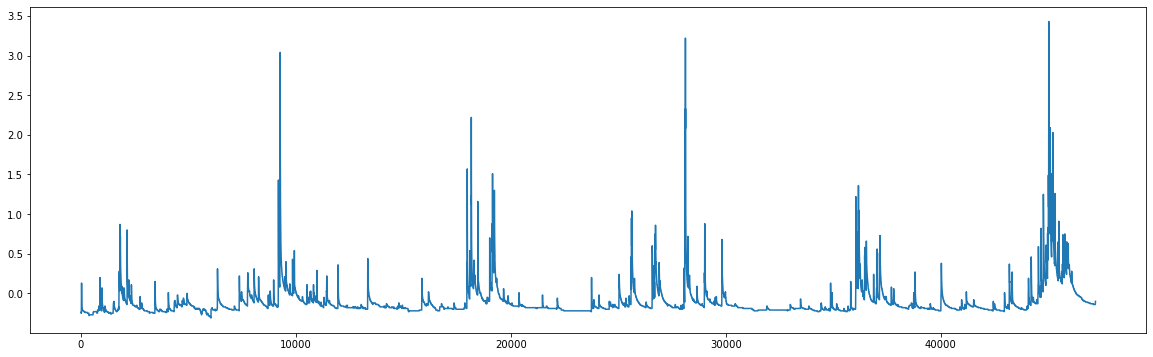

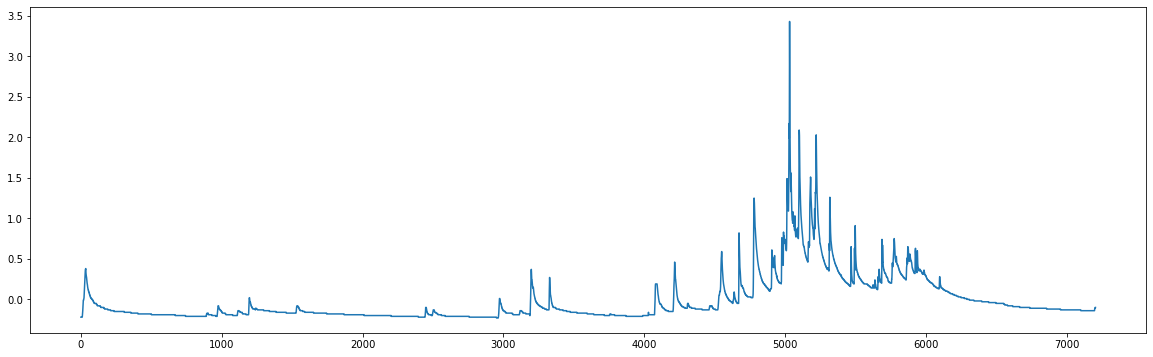

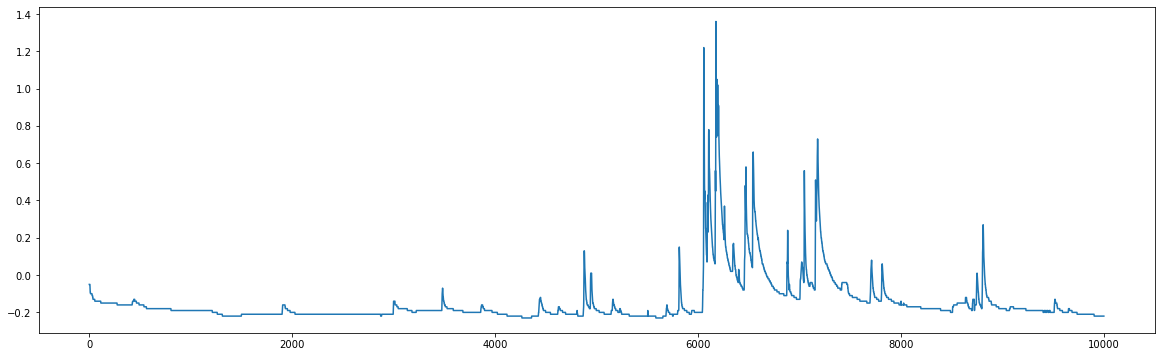

In [26]:
plt.figure(figsize=(20,6))
plt.plot(dataset_y_reshaped)
plt.show()

plt.figure(figsize=(20,6))
plt.plot(dataset_y_reshaped[40000:])
plt.show()

plt.figure(figsize=(20,6))
plt.plot(dataset_y_reshaped[30000:40000])
plt.show()

In [27]:
#X_train, X_test, y_train, y_test = train_test_split(dataset_X_reshaped, dataset_y_reshaped, test_size=0.01)

# 50000번째 까지를 훈련데이터셋으로
# 그이후를 테스트데이터셋으로 구성함
X_train = dataset_X_reshaped[0:30000,:,:]
X_val = dataset_X_reshaped[30000:40000,:,:]
X_test = dataset_X_reshaped[40000:,:,:]

y_train = dataset_y_reshaped[0:30000]
y_val = dataset_y_reshaped[30000:40000]
y_test = dataset_y_reshaped[40000:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(30000, 240, 8)
(7205, 240, 8)
(30000, 1)
(7205, 1)


In [28]:
drop_out_rate = 0.05

In [ ]:
# 기본 lstm모형을 생성
# lstm 은 stacked lstm형태로, stacked될 경우 return_sequence = TRUE 옵션 필요
# training=True옵션을 통해 dropout을 이용하여 매번 다른 결과값이 생성됨
# early stopping을 적용하여, 최적의 epoch를 결정함
# 현재 patience는 5로 설정되어 있음


def base_lstm(X_train, y_train, verbose = 1):
  inputs = Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
  x = LSTM(256, return_sequences=True, recurrent_dropout=drop_out_rate)(inputs, training=True) 
  x = LSTM(256, recurrent_dropout=drop_out_rate)(x, training=True) 
  x = Dropout(drop_out_rate)(x, training=True) 
  output = Dense(units = 1, activation='linear', name='OUTPUT')(x)
  model = Model(inputs=inputs, outputs=output)
  opt = Adam()
  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  
  epc = 1000
  es = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epc, verbose=verbose, callbacks=[es], 
                      batch_size=1024)
  return model
 
model_base = base_lstm(X_train, y_train)


Epoch 1/1000


In [ ]:
def base_1dcnn(X_train, y_train, verbose = 1):
  inputs = Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
  x = Conv1D(filters = 256, kernel_size = 3, padding='valid')(inputs) 
  x = MaxPooling1D(3)(x)
  x = Conv1D(filters = 256, kernel_size = 3, padding='valid')(x) 
  x = MaxPooling1D(3)(x)
  x = Flatten()(x)
  x = Dropout(drop_out_rate)(x, training=True) 
  output = Dense(units = 1, activation='linear', name='OUTPUT')(x)
  model = Model(inputs=inputs, outputs=output)
  opt = Adam()
  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  
  epc = 1000
  es = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epc, verbose=verbose, callbacks=[es], 
                      batch_size=1024)
  return model
 
model_1dcnn = base_1dcnn(X_train, y_train)


Train on 30000 samples, validate on 10000 samples
Epoch 1/1000
30000/30000 [==============================] - 5s 174us/step - loss: 0.0146 - mae: 0.0629 - val_loss: 0.0050 - val_mae: 0.0403
Epoch 2/1000
30000/30000 [==============================] - 5s 157us/step - loss: 0.0077 - mae: 0.0325 - val_loss: 0.0037 - val_mae: 0.0299
Epoch 3/1000
30000/30000 [==============================] - 5s 156us/step - loss: 0.0071 - mae: 0.0287 - val_loss: 0.0037 - val_mae: 0.0287
Epoch 4/1000
30000/30000 [==============================] - 5s 158us/step - loss: 0.0067 - mae: 0.0297 - val_loss: 0.0032 - val_mae: 0.0198
Epoch 5/1000
30000/30000 [==============================] - 5s 158us/step - loss: 0.0063 - mae: 0.0264 - val_loss: 0.0033 - val_mae: 0.0180
Epoch 6/1000
30000/30000 [==============================] - 5s 157us/step - loss: 0.0058 - mae: 0.0254 - val_loss: 0.0033 - val_mae: 0.0213
Epoch 7/1000
30000/30000 [==============================] - 5s 157us/step - loss: 0.0056 - mae: 0.0269 - val_l

In [ ]:
def base_dnn(X_train, y_train, verbose = 1):
  inputs = Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
  x = Flatten()(inputs)
  x = Dense(256, activation='relu')(x)
  x = Dropout(drop_out_rate)(x, training=True) 
  x = Dense(256,activation='relu')(x)
  x = Dropout(drop_out_rate)(x, training=True) 
  output = Dense(units = 1, activation='linear', name='OUTPUT')(x)
  model = Model(inputs=inputs, outputs=output)
  opt = Adam()
  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  
  epc = 1000
  es = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epc, verbose=verbose, callbacks=[es], 
                      batch_size=1024)

  return model
 
model_dnn = base_dnn(X_train, y_train)



Train on 30000 samples, validate on 10000 samples
Epoch 1/1000
30000/30000 [==============================] - 1s 33us/step - loss: 0.0204 - mae: 0.0947 - val_loss: 0.0053 - val_mae: 0.0507
Epoch 2/1000
30000/30000 [==============================] - 1s 21us/step - loss: 0.0045 - mae: 0.0432 - val_loss: 0.0025 - val_mae: 0.0376
Epoch 3/1000
30000/30000 [==============================] - 1s 21us/step - loss: 0.0019 - mae: 0.0279 - val_loss: 0.0011 - val_mae: 0.0215
Epoch 4/1000
30000/30000 [==============================] - 1s 20us/step - loss: 0.0011 - mae: 0.0208 - val_loss: 6.3739e-04 - val_mae: 0.0164
Epoch 5/1000
30000/30000 [==============================] - 1s 21us/step - loss: 8.5842e-04 - mae: 0.0183 - val_loss: 7.9908e-04 - val_mae: 0.0197
Epoch 6/1000
30000/30000 [==============================] - 1s 21us/step - loss: 7.3399e-04 - mae: 0.0168 - val_loss: 6.8362e-04 - val_mae: 0.0188
Epoch 7/1000
30000/30000 [==============================] - 1s 20us/step - loss: 6.8863e-04 - ma

In [ ]:
# 테스트 데이터셋에서 수위가 가장높았던 상위 10개 시점의 인덱스를 구함

idx = (-y_test).argsort(axis=None)[:10]
idx

array([5032, 5033, 5031, 5034, 5028, 5100, 5101, 5035, 5221, 5102])

In [ ]:
# 위에서 뽑은 인덱스로 데이터셋을 구성
X_test_high_top10 = X_test[np.array(idx)]
y_test_high_top10 = y_test[np.array(idx)]

In [ ]:
# save model
def save_model(model, fn) :
  json_model = model.to_json()
  json_file = open(fn + '.json', 'w')
  json_file.write(json_model)
  model.save(fn + '.h5')

save_model(model_base, path + 'lstm_base_jingwan_w_diff1')
save_model(model_1dcnn, path + 'lstm_1dcnn_jingwan_w_diff1')
save_model(model_dnn, path + 'dnn_jingwan_w_diff1')


In [ ]:
def predict_dist(X, model, num_samples):
    preds = [model.predict(X) for _ in range(num_samples)]
    return np.hstack(preds)

In [ ]:
# 하나의 데이터셋에 대해 30개의 예측치를 도출하고,
# 이것의 평균과 분산을 구함
model = model_base

y_pred_dist = predict_dist(X_test_high_top10, model, 30)
pred_mean = y_pred_dist.mean(axis=1)
pred_std = y_pred_dist.std(axis=1)

display(pd.DataFrame({'Obs' : y_test_high_top10.flatten(), 'Pred' : pred_mean.flatten()}))

from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(pred_mean.flatten(), y_test_high_top10.flatten()) 
np.sqrt(MSE)

,Obs,Pred
0,3.43,3.406360
1,2.90,2.990806
2,2.54,2.251970
3,2.40,2.428890
4,2.17,1.809208
5,2.09,2.067301
6,2.07,2.059524
7,2.03,2.188832
8,2.03,1.963726
9,2.02,1.980106


0.15956447116123856

In [ ]:
# 하나의 데이터셋에 대해 30개의 예측치를 도출하고,
# 이것의 평균과 분산을 구함
model = model_1dcnn

y_pred_dist = predict_dist(X_test_high_top10, model, 30)
pred_mean = y_pred_dist.mean(axis=1)
pred_std = y_pred_dist.std(axis=1)

display(pd.DataFrame({'Obs' : y_test_high_top10.flatten(), 'Pred' : pred_mean.flatten()}))

from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(pred_mean.flatten(), y_test_high_top10.flatten()) 
np.sqrt(MSE)

,Obs,Pred
0,3.43,0.759896
1,2.90,0.806452
2,2.54,0.712934
3,2.40,0.950282
4,2.17,0.833362
5,2.09,0.754061
6,2.07,0.747642
7,2.03,1.044220
8,2.03,0.926866
9,2.02,0.771752


1.613040821726875

In [ ]:
# 하나의 데이터셋에 대해 30개의 예측치를 도출하고,
# 이것의 평균과 분산을 구함
model = model_dnn

y_pred_dist = predict_dist(X_test_high_top10, model, 30)
pred_mean = y_pred_dist.mean(axis=1)
pred_std = y_pred_dist.std(axis=1)

display(pd.DataFrame({'Obs' : y_test_high_top10.flatten(), 'Pred' : pred_mean.flatten()}))

from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(pred_mean.flatten(), y_test_high_top10.flatten()) 
np.sqrt(MSE)

,Obs,Pred
0,3.43,2.878142
1,2.90,3.022812
2,2.54,2.002388
3,2.40,2.686136
4,2.17,1.607533
5,2.09,1.823436
6,2.07,1.947470
7,2.03,2.254786
8,2.03,1.782384
9,2.02,1.982273


0.3473089308398154

In [ ]:
strix = 40000

X_test = dataset_X_reshaped[strix:,:,:]
y_test = dataset_y_reshaped[strix:]

print(X_test.shape)
print(y_test.shape)

(7205, 240, 8)
(7205, 1)


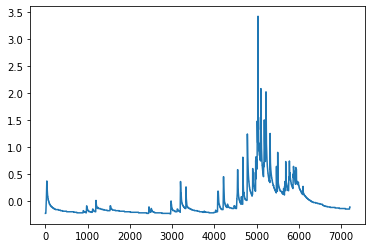

In [ ]:
plt.plot(y_test)

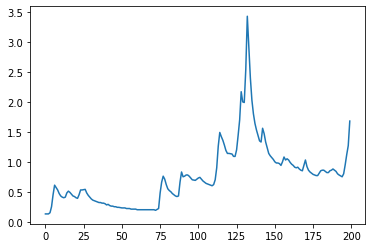

In [ ]:
plt.plot(y_test[4900:5100])

In [ ]:
y_pred_dist = predict_dist(X_test[4900:5100], model_base, 30)
pred_mean = y_pred_dist.mean(axis=1)
pred_std = y_pred_dist.std(axis=1)

In [ ]:
prob_advisory = [] # 4m
prob_warning = [] # 5m

threshold_advisory = 2
threshold_warning = 3

for i in range(0,len(y_pred_dist)) :
  ecdf = ECDF(y_pred_dist[i])
  prob_advisory.append(1 - ecdf(2))
  prob_warning.append(1 - ecdf(3))

In [ ]:
y_test[4900:5100][:10]

array([[0.13],
       [0.13],
       [0.13],
       [0.15],
       [0.25],
       [0.45],
       [0.61],
       [0.57],
       [0.53],
       [0.47]])

In [ ]:
a = df[df_in['1018630'] == 0.13].index + 8
b = df[df_in['1018630'] == 0.13].index + 7
c = df[df_in['1018630'] == 0.13].index + 6
d = df[df_in['1018630'] == 0.15].index + 5
e = df[df_in['1018630'] == 0.25].index + 4
f = df[df_in['1018630'] == 0.45].index + 3
g = df[df_in['1018630'] == 0.61].index + 2
h = df[df_in['1018630'] == 0.57].index + 1
i = df[df_in['1018630'] == 0.53].index


list(set(a) & set(b) & set(c) & set(d) & set(e) & set(f) & set(g) & set(h) & set(i))

[45990]

In [ ]:
df[(45990-8):]

,Date,ymdh,1018620,1018625,1018630,10184110,10184220
45982,2020-07-28 23:00:00,2020072823,0.39,1.17,0.13,0.0,0.0
45983,2020-07-29 00:00:00,2020072900,0.39,1.17,0.13,0.0,0.0
45984,2020-07-29 01:00:00,2020072901,0.39,1.17,0.13,0.0,0.0
45985,2020-07-29 02:00:00,2020072902,0.39,1.17,0.15,19.0,0.0
45986,2020-07-29 03:00:00,2020072903,0.39,1.20,0.25,5.0,8.0
...,...,...,...,...,...,...,...
48282,2020-11-01 19:00:00,2020110119,0.15,1.07,-0.11,0.0,0.0
48283,2020-11-01 20:00:00,2020110120,0.15,1.07,-0.11,0.0,0.0
48284,2020-11-01 21:00:00,2020110121,0.15,1.07,-0.10,0.0,0.0
48285,2020-11-01 22:00:00,2020110122,0.15,1.08,-0.10,0.0,0.0


In [ ]:
strix = 45982
num = 200

df_pred = pd.DataFrame({'Date' : df['Date'][strix:strix+num].values, 'Obs' : y_test[4900:5100].flatten(), 'Pred' : pred_mean.flatten(), 'Upper' : pred_mean + 1.96 * pred_std, 'Lower' : pred_mean - 1.96 * pred_std, 'Prob_adv' : prob_advisory, 'Prob_warn' : prob_warning})
#df_pred = df_pred.merge(df[['Date', '10184110', '10184220']], how='left', on = 'Date')
df_pred

,Date,Obs,Pred,Upper,Lower,Prob_adv,Prob_warn
0,2020-07-28 23:00:00,0.13,0.123466,0.133394,0.113539,0.0,0.0
1,2020-07-29 00:00:00,0.13,0.121538,0.130008,0.113067,0.0,0.0
2,2020-07-29 01:00:00,0.13,0.121851,0.131446,0.112256,0.0,0.0
3,2020-07-29 02:00:00,0.15,0.122054,0.130997,0.113111,0.0,0.0
4,2020-07-29 03:00:00,0.25,0.202835,0.212234,0.193436,0.0,0.0
...,...,...,...,...,...,...,...
195,2020-08-06 02:00:00,0.80,0.773455,0.811279,0.735631,0.0,0.0
196,2020-08-06 03:00:00,0.95,0.896786,0.938607,0.854965,0.0,0.0
197,2020-08-06 04:00:00,1.12,1.080854,1.127204,1.034503,0.0,0.0
198,2020-08-06 05:00:00,1.27,1.253034,1.301044,1.205023,0.0,0.0


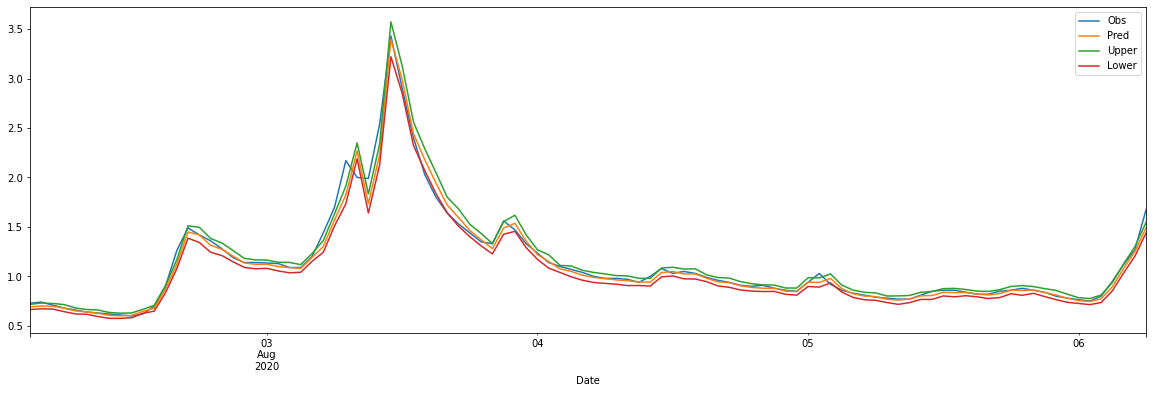

In [ ]:
df_pred[['Date', 'Obs', 'Pred', 'Upper', 'Lower']][100:200].set_index('Date').plot(figsize=(20,6))

In [ ]:
# 하나의 데이터셋에 대해 30개의 예측치를 도출하고,
# 이것의 평균과 분산을 구함

y_pred_dist = predict_dist(X_test_high_top10, model_base, 30)
pred_mean = y_pred_dist.mean(axis=1)
pred_std = y_pred_dist.std(axis=1)

In [ ]:
pd.DataFrame({'Obs' : y_test_high_top10.flatten(), 'Pred' : pred_mean.flatten()})

,Obs,Pred
0,3.43,3.244029
1,2.90,3.088189
2,2.54,2.154109
3,2.40,2.337663
4,2.17,1.786714
5,2.09,2.154751
6,2.07,2.027051
7,2.03,2.007719
8,2.03,2.155474
9,2.02,1.936406


In [ ]:

from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(pred_mean.flatten(), y_test_high_top10.flatten()) 
np.sqrt(MSE)

0.19974280876797443

In [ ]:
pred_std.mean()

0.36188784

In [ ]:
y_pred_dist = predict_dist(X_test_high_top10, model_attention, 30)
pred_mean = y_pred_dist.mean(axis=1)
pred_std = y_pred_dist.std(axis=1)

In [ ]:
pd.DataFrame({'Obs' : y_test_high_top10.flatten(), 'Pred' : pred_mean.flatten()})

,Obs,Pred
0,3.43,3.381618
1,2.90,3.044443
2,2.54,2.092112
3,2.40,2.546868
4,2.17,1.748173
5,2.09,1.991827
6,2.07,2.031450
7,2.03,2.192280
8,2.03,1.994970
9,2.02,1.976665


In [ ]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(pred_mean.flatten(), y_test_high_top10.flatten()) 
np.sqrt(MSE)

0.2153788609340985

In [ ]:
pred_std.mean()

0.22864859

In [ ]:
y_pred_dist = predict_dist(X_test_high_top10, model_dnn, 30)
pred_mean = y_pred_dist.mean(axis=1)
pred_std = y_pred_dist.std(axis=1)

In [ ]:
pd.DataFrame({'Obs' : y_test_high_top10.flatten(), 'Pred' : pred_mean.flatten()})

,Obs,Pred
0,3.43,2.928988
1,2.90,3.019025
2,2.54,2.047607
3,2.40,2.628680
4,2.17,1.630818
5,2.09,1.816654
6,2.07,1.919950
7,2.03,2.151844
8,2.03,1.935551
9,2.02,1.924715


In [ ]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(pred_mean.flatten(), y_test_high_top10.flatten()) 
np.sqrt(MSE)

0.31316464507109043

In [ ]:
pred_std.mean()

3.0994414e-07

In [ ]:
y_pred_dist = predict_dist(X_test_high_top10, model_base, 30)
pred_mean = y_pred_dist.mean(axis=1)
pred_std = y_pred_dist.std(axis=1)

In [ ]:
strix = 57695 - 240
endix = 58031 - 240

X_test = dataset_X_reshaped[strix:endix,:,:]
y_test = dataset_y_reshaped[strix:endix]

print(X_test.shape)
print(y_test.shape)

(336, 240, 5)
(336, 1)


In [ ]:
y_pred_dist = predict_dist(X_test, model, 30)
pred_mean = y_pred_dist.mean(axis=1)
pred_std = y_pred_dist.std(axis=1)

In [ ]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(pred_mean.flatten(), y_test.flatten()) 
np.sqrt(MSE)

0.17888402450346685

In [ ]:
prob_advisory = [] # 2m
prob_warning = [] # 3m

threshold_advisory = 2
threshold_warning = 3

for i in range(0,len(y_pred_dist)) :
  ecdf = ECDF(y_pred_dist[i])
  prob_advisory.append(1 - ecdf(2))
  prob_warning.append(1 - ecdf(3))

In [ ]:
df_pred = pd.DataFrame({'Date' : df['Date'][(strix+240):(endix+240)].values, 'Obs' : y_test.flatten(), 'Pred' : pred_mean.flatten(), 'Upper' : pred_mean + 1.96 * pred_std, 'Lower' : pred_mean - 1.96 * pred_std, 'Prob_adv' : prob_advisory, 'Prob_warn' : prob_warning})
df_pred[50:70]

,Date,Obs,Pred,Upper,Lower,Prob_adv,Prob_warn
50,2020-08-03 02:00:00,1.09,0.847931,1.036669,0.659194,0.000000,0.000000
51,2020-08-03 03:00:00,1.09,0.869091,1.090074,0.648109,0.000000,0.000000
52,2020-08-03 04:00:00,1.20,0.935072,1.107319,0.762825,0.000000,0.000000
53,2020-08-03 05:00:00,1.44,1.060626,1.264004,0.857249,0.000000,0.000000
54,2020-08-03 06:00:00,1.70,1.173816,1.423159,0.924472,0.000000,0.000000
55,2020-08-03 07:00:00,2.17,1.301747,1.572533,1.030960,0.000000,0.000000
56,2020-08-03 08:00:00,2.00,1.540463,1.847558,1.233368,0.000000,0.000000
57,2020-08-03 09:00:00,1.99,1.589831,1.966612,1.213050,0.033333,0.000000
58,2020-08-03 10:00:00,2.54,1.760803,2.319821,1.201785,0.200000,0.000000
59,2020-08-03 11:00:00,3.43,2.203792,2.688916,1.718668,0.833333,0.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


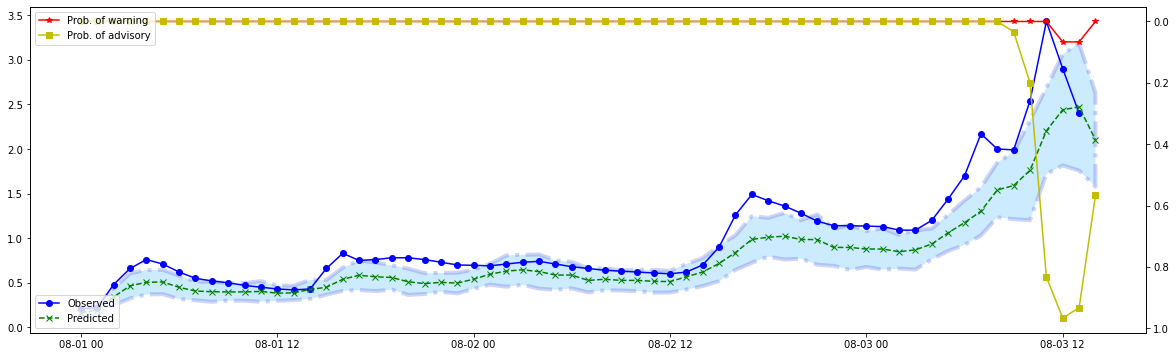

In [ ]:
df_predict = df_pred[0:63].copy()
df_predict['Obs'][62] = float("nan")

fig, ax1 = plt.subplots(figsize=(20,6))

ax2 = ax1.twinx()
ax1.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax1.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax1.fill_between(df_predict['Date'], df_predict['Lower'], df_predict['Upper'],
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                 linewidth=4, linestyle='dashdot', antialiased=True)

ax1.legend(('Observed','Predicted'), loc='lower left')


ax2.plot(df_predict['Date'], df_predict['Prob_warn'], 'r-', marker='*')
ax2.plot(df_predict['Date'], df_predict['Prob_adv'], 'y-', marker='s')
ax2.legend(('Prob. of warning','Prob. of advisory'), loc='upper left')

ax2.invert_yaxis()

In [ ]:
import matplotlib.animation as animation

fig, ax1 = plt.subplots(figsize=(20,6), frameon=False)

ax2 = ax1.twinx()
ax1.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax1.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax1.fill_between(df_predict['Date'], df_predict['Lower'], df_predict['Upper'],
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                 linewidth=4, linestyle='dashdot', antialiased=True)

ax1.legend(('Observed','Predicted'), loc='lower left')

ax2.plot(df_predict['Date'], df_predict['Prob_warn'], 'r-', marker='*')
ax2.plot(df_predict['Date'], df_predict['Prob_adv'], 'y-', marker='s')
ax2.legend(('Prob. of warning','Prob. of advisory'), loc='upper left')

ax2.invert_yaxis()

def update(frame):
  df_predict = df_pred[0:frame].copy()
  df_predict['Obs'][frame-1] = float("nan")


ani = FuncAnimation(
        fig=f, func=update,
        frames=128, 
        blit=False, 
        )









/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


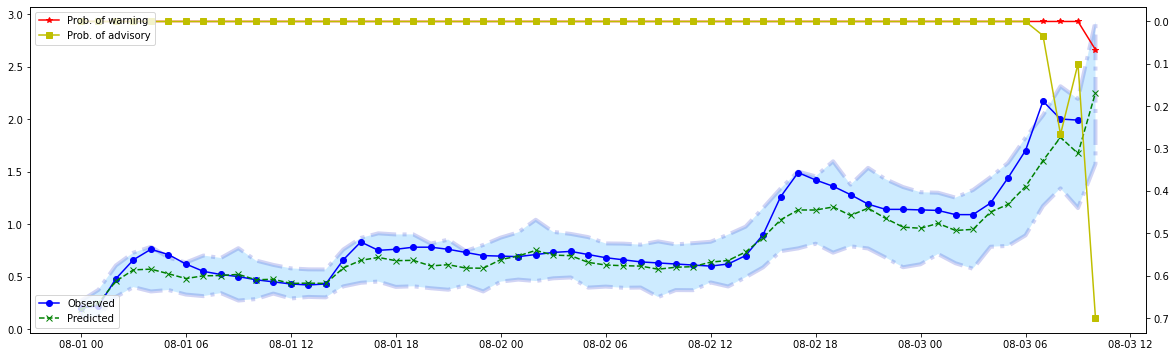

In [ ]:

df_predict = df_pred[0:59].copy()
df_predict['Obs'][58] = float("nan")

fig, ax1 = plt.subplots(figsize=(20,6))

ax2 = ax1.twinx()
ax1.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax1.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax1.fill_between(df_predict['Date'], df_predict['Lower'], df_predict['Upper'],
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                 linewidth=4, linestyle='dashdot', antialiased=True)

ax1.legend(('Observed','Predicted'), loc='lower left')


ax2.plot(df_predict['Date'], df_predict['Prob_warn'], 'r-', marker='*')
ax2.plot(df_predict['Date'], df_predict['Prob_adv'], 'y-', marker='s')
ax2.legend(('Prob. of warning','Prob. of advisory'), loc='upper left')

ax2.invert_yaxis()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


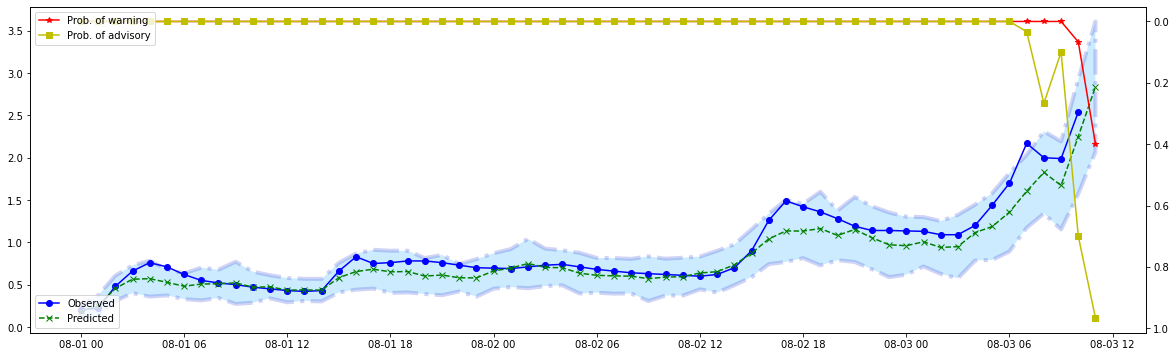

In [ ]:
df_predict = df_pred[0:60].copy()
df_predict['Obs'][59] = float("nan")

fig, ax1 = plt.subplots(figsize=(20,6))

ax2 = ax1.twinx()
ax1.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax1.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax1.fill_between(df_predict['Date'], df_predict['Lower'], df_predict['Upper'],
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                 linewidth=4, linestyle='dashdot', antialiased=True)

ax1.legend(('Observed','Predicted'), loc='lower left')


ax2.plot(df_predict['Date'], df_predict['Prob_warn'], 'r-', marker='*')
ax2.plot(df_predict['Date'], df_predict['Prob_adv'], 'y-', marker='s')
ax2.legend(('Prob. of warning','Prob. of advisory'), loc='upper left')

ax2.invert_yaxis()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


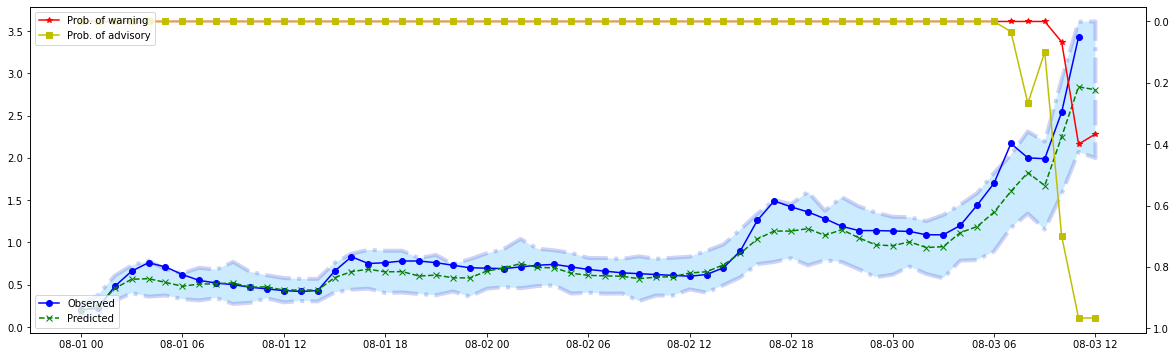

In [ ]:
df_predict = df_pred[0:61].copy()
df_predict['Obs'][60] = float("nan")

fig, ax1 = plt.subplots(figsize=(20,6))

ax2 = ax1.twinx()
ax1.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax1.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax1.fill_between(df_predict['Date'], df_predict['Lower'], df_predict['Upper'],
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                 linewidth=4, linestyle='dashdot', antialiased=True)

ax1.legend(('Observed','Predicted'), loc='lower left')


ax2.plot(df_predict['Date'], df_predict['Prob_warn'], 'r-', marker='*')
ax2.plot(df_predict['Date'], df_predict['Prob_adv'], 'y-', marker='s')
ax2.legend(('Prob. of warning','Prob. of advisory'), loc='upper left')

ax2.invert_yaxis()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


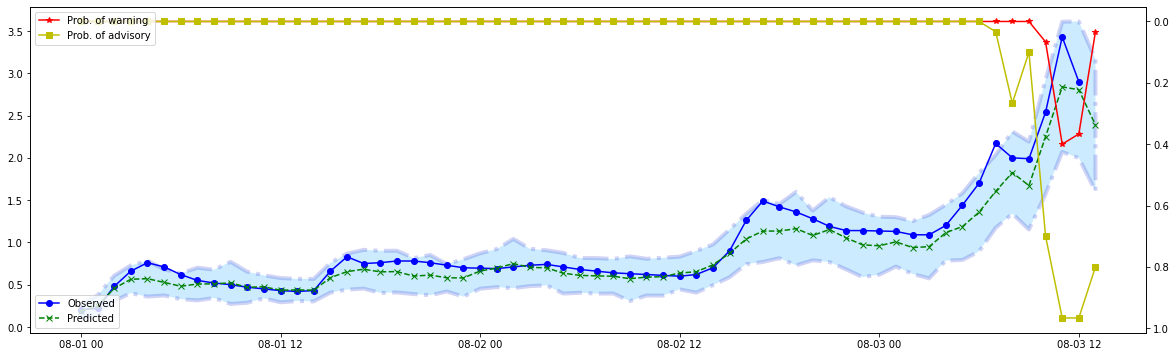

In [ ]:
df_predict = df_pred[0:62].copy()
df_predict['Obs'][61] = float("nan")

fig, ax1 = plt.subplots(figsize=(20,6))

ax2 = ax1.twinx()
ax1.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax1.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax1.fill_between(df_predict['Date'], df_predict['Lower'], df_predict['Upper'],
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                 linewidth=4, linestyle='dashdot', antialiased=True)

ax1.legend(('Observed','Predicted'), loc='lower left')


ax2.plot(df_predict['Date'], df_predict['Prob_warn'], 'r-', marker='*')
ax2.plot(df_predict['Date'], df_predict['Prob_adv'], 'y-', marker='s')
ax2.legend(('Prob. of warning','Prob. of advisory'), loc='upper left')

ax2.invert_yaxis()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


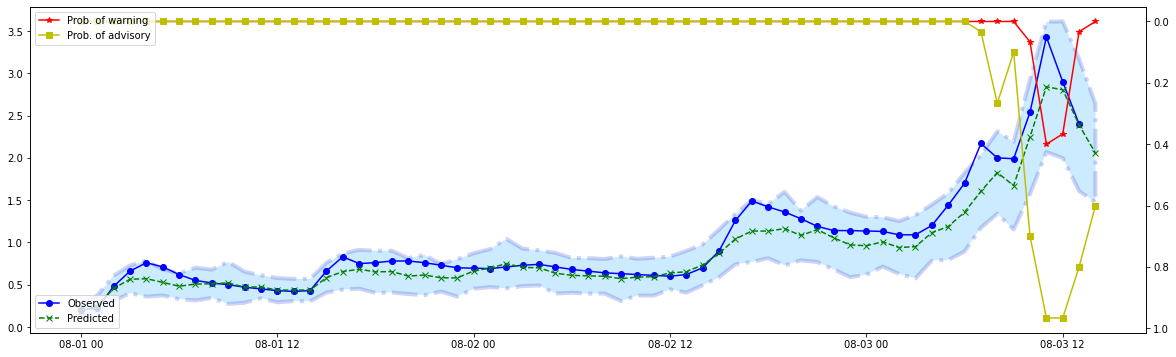

In [ ]:
df_predict = df_pred[0:63].copy()
df_predict['Obs'][62] = float("nan")

fig, ax1 = plt.subplots(figsize=(20,6))

ax2 = ax1.twinx()
ax1.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax1.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax1.fill_between(df_predict['Date'], df_predict['Lower'], df_predict['Upper'],
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                 linewidth=4, linestyle='dashdot', antialiased=True)

ax1.legend(('Observed','Predicted'), loc='lower left')


ax2.plot(df_predict['Date'], df_predict['Prob_warn'], 'r-', marker='*')
ax2.plot(df_predict['Date'], df_predict['Prob_adv'], 'y-', marker='s')
ax2.legend(('Prob. of warning','Prob. of advisory'), loc='upper left')

ax2.invert_yaxis()